# Getting Started

In [1]:
''' Required for Google Colab'''

# Mount GDrive
# from google.colab import drive
# drive.mount('/content/drive')

# # Upload Kaggle json

# !pip install -q kaggle
# !pip install -q kaggle-cli
# !mkdir -p ~/.kaggle
# !cp "/content/drive/My Drive/Kaggle/kaggle.json" ~/.kaggle/
# !cat ~/.kaggle/kaggle.json 
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle competitions download -c fake-news -p dataset
# !unzip /content/dataset/train.csv.zip
# !unzip /content/dataset/test.csv.zip

' Required for Google Colab'

In [2]:
''' Required for Google Colab'''
# !pip install contractions

' Required for Google Colab'

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams['figure.figsize'] = [10,10]
import seaborn as sns
sns.set_theme(style="darkgrid")
from wordcloud import WordCloud

import contractions
import string
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from keras.layers import Flatten

import warnings
warnings.filterwarnings('ignore')

In [4]:
''' Required for Google Colab'''
# train_df = pd.read_csv('/content/train.csv', header=0)
# test_df = pd.read_csv('/content/test.csv', header=0)

' Required for Google Colab'

In [5]:
train_df = pd.read_csv('fake-news/train.csv', header=0)
test_df = pd.read_csv('fake-news/test.csv', header=0)

In [6]:
train_df = train_df.fillna(' ')
test_df = test_df.fillna(' ')

In [7]:
train_df['all_info'] = train_df['text'] + train_df['title'] + train_df['author']
test_df['all_info'] = test_df['text'] + test_df['title'] + test_df['author']

# Tokenize and Prep Text Data

Here, I have used Keras API's Tokenizer class to tokenize the texts, where I have set the Out of Vocabulary (OOV) token and the number of words which is the maximum number of words to retain, based on word frequency. Next, I fit the Tokenizer on text to map the tokens to integers. Finally, I encoded the training set with the integer representations using texts_to_sequences() and split the data to use 20% for validation.

In [8]:
tokenizer = Tokenizer(oov_token = "<OOV>", num_words=6000)
tokenizer.fit_on_texts(train_df['all_info'])

In [9]:
target = train_df['label'].values

In [10]:
max_length = 40
vocab_size = 6000

sequences_train = tokenizer.texts_to_sequences(train_df['all_info'])
sequences_test = tokenizer.texts_to_sequences(test_df['all_info'])

padded_train = pad_sequences(sequences_train, padding = 'post', maxlen=max_length)
padded_test = pad_sequences(sequences_test, padding = 'post', maxlen=max_length)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(padded_train, target, test_size=0.2)

In [12]:
X_train.shape, y_train.shape

((16640, 40), (16640,))

# Simple Binary Classification Model

To create a model for text classification, I started with the simplest form of DL binary classification model structure. I also used early stopping to save time with patience=15 which indictes to stop if in the last 15 epochs there were no improvement in the model, and model checkpoint to store the best model with save_best_only=True. Added mode=min since we monitoring loss here.

In [13]:
best_model_file_name = "models/best_model_simple.hdf5"

In [14]:
def get_simple_model():
    model = Sequential()
    model.add(Embedding(vocab_size, 10, input_length=max_length))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [15]:
callbacks=[
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, 
                                  verbose=1, mode="min", restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath=best_model_file_name, verbose=1, save_best_only=True)
]

In [16]:
model = get_simple_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 10)            60000     
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 401       
Total params: 60,401
Trainable params: 60,401
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [18]:
%%time
history = model.fit(X_train, 
                    y_train, 
                    epochs=20,
                    validation_data=(X_test, y_test), 
                    callbacks=callbacks)

Epoch 1/20
510/520 [============================>.] - ETA: 0s - loss: 0.4327 - precision: 0.8546 - recall: 0.8153
Epoch 00001: val_loss improved from inf to 0.19978, saving model to models\best_model_simple.hdf5
520/520 [==============================] - 3s 5ms/step - loss: 0.4277 - precision: 0.8561 - recall: 0.8183 - val_loss: 0.1998 - val_precision: 0.8997 - val_recall: 0.9788
Epoch 2/20
501/520 [===========================>..] - ETA: 0s - loss: 0.1348 - precision: 0.9355 - recall: 0.9819
Epoch 00002: val_loss improved from 0.19978 to 0.11952, saving model to models\best_model_simple.hdf5
520/520 [==============================] - 2s 3ms/step - loss: 0.1341 - precision: 0.9359 - recall: 0.9820 - val_loss: 0.1195 - val_precision: 0.9401 - val_recall: 0.9803
Epoch 3/20
513/520 [============================>.] - ETA: 0s - loss: 0.0760 - precision: 0.9680 - recall: 0.9880
Epoch 00003: val_loss improved from 0.11952 to 0.09778, saving model to models\best_model_simple.hdf5
520/520 [=====

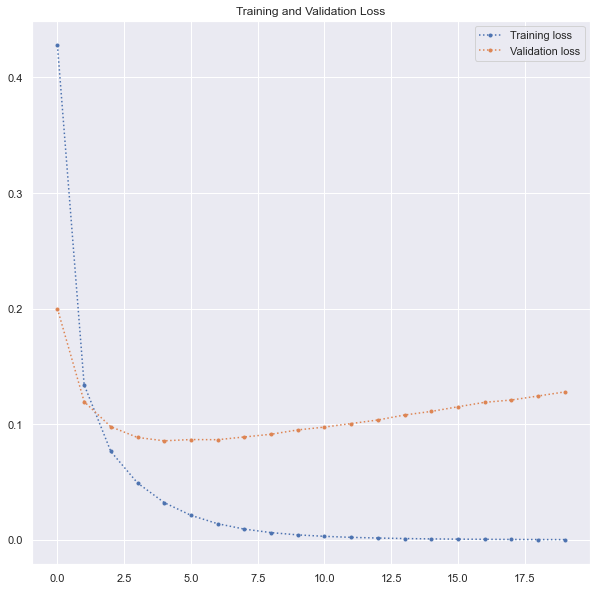

In [19]:
metric_to_plot = "loss"
plt.plot(history.epoch, history.history[metric_to_plot], ".:", label="Training loss")
plt.plot(history.epoch, history.history["val_" + metric_to_plot], ".:", label="Validation loss")
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [20]:
history.history.keys()

dict_keys(['loss', 'precision', 'recall', 'val_loss', 'val_precision', 'val_recall'])

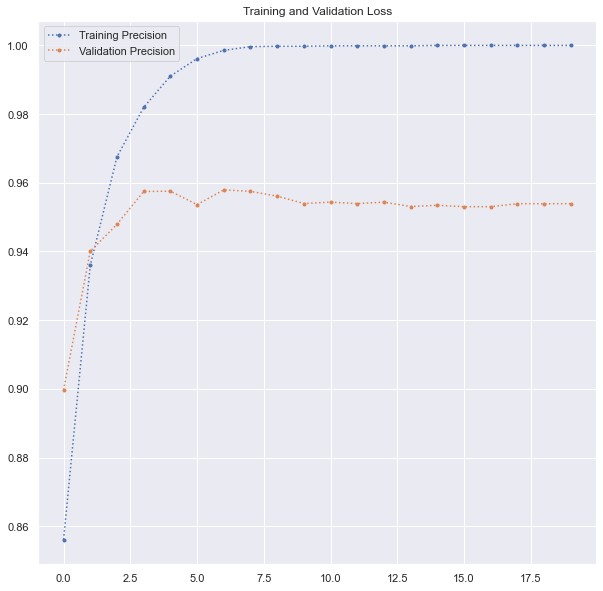

In [21]:
metric_to_plot = "precision"
plt.plot(history.epoch, history.history[metric_to_plot], ".:", label="Training Precision")
plt.plot(history.epoch, history.history["val_" + metric_to_plot], ".:", label="Validation Precision")
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

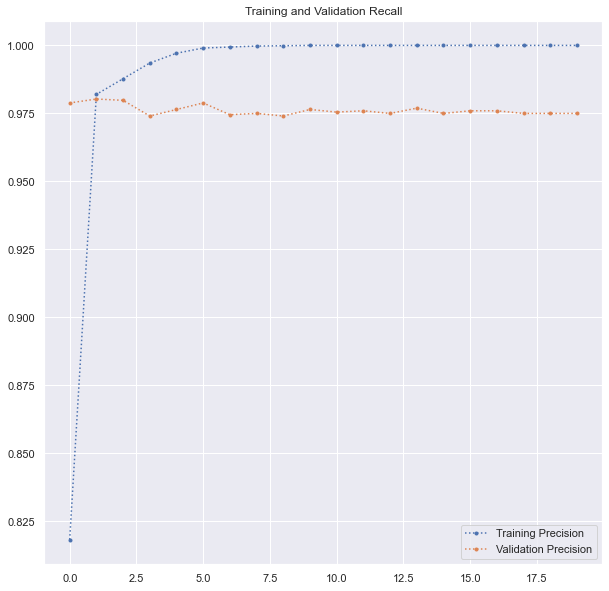

In [22]:
metric_to_plot = "recall"
plt.plot(history.epoch, history.history[metric_to_plot], ".:", label="Training Precision")
plt.plot(history.epoch, history.history["val_" + metric_to_plot], ".:", label="Validation Precision")
plt.title('Training and Validation Recall')
plt.legend()
plt.show()

In [23]:
model = keras.models.load_model(best_model_file_name)
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))

Accuracy:  0.9665865384615384
Precision:  0.9575671852899575
Recall:  0.9764423076923077
F1 Score:  0.9669126398476553


# Using LSTM Model for Text Classification

In [24]:
%%time

best_model_file_name = "models/best_model_simple_LSTM.hdf5"
def get_simple_LSTM_model():
    model = Sequential()
    model.add(Embedding(vocab_size, 10, input_length=max_length))
    model.add(Dropout(0.3))
    model.add(LSTM(100))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    return model

callbacks=[
    keras.callbacks.EarlyStopping(monitor="val_loss", 
                                  patience=15, 
                                  verbose=1, 
                                  mode="min", 
                                  restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath=best_model_file_name, 
                                    verbose=1, 
                                    save_best_only=True)
]

model = get_simple_LSTM_model()
print(model.summary())

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

history = model.fit(X_train, 
                    y_train, 
                    epochs=20, 
                    validation_data=(X_test, y_test), 
                    callbacks=callbacks)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 10)            60000     
_________________________________________________________________
dropout (Dropout)            (None, 40, 10)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               44400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

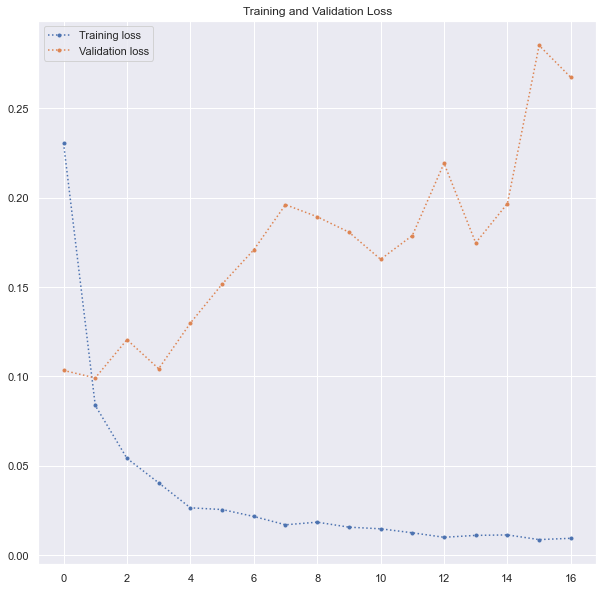

In [25]:
metric_to_plot = "loss"
plt.plot(history.epoch, history.history[metric_to_plot], ".:", label="Training loss")
plt.plot(history.epoch, history.history["val_" + metric_to_plot], ".:", label="Validation loss")
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [26]:
model = keras.models.load_model(best_model_file_name)
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))

Accuracy:  0.9617788461538461
Precision:  0.9432395016151361
Recall:  0.9826923076923076
F1 Score:  0.9625618083352955


# Using Pre-trained GloVe Embedding

https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

In [27]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove*.zip

In [28]:
embeddings_index = dict()
# f = open('/content/glove.6B.300d.txt')
f = open('C:/Users/nroy0/Documents/MyGitHub/Resources/glove.6B/glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded {} word vectors.'.format(len(embeddings_index)))

Loaded 400000 word vectors.


In [29]:
%%time
# create a weight matrix for words in training docs
print('Get vocab_size')
vocab_size = len(tokenizer.word_index) + 1

print('Create the embedding matrix')
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Get vocab_size
Create the embedding matrix
Wall time: 889 ms


## Simple Classification Model

In [30]:
best_model_file_name = "models/best_model_simple_with_GloVe.hdf5"

def get_simple_GloVe_model():
    model = Sequential()
    model.add(Embedding(vocab_size, 
                        300, 
                        weights=[embedding_matrix], 
                        input_length=max_length,
                        trainable=False))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

callbacks=[
    keras.callbacks.EarlyStopping(monitor="val_loss", 
                                  patience=15, 
                                  verbose=1, 
                                  mode="min", 
                                  restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath=best_model_file_name, 
                                    verbose=1, 
                                    save_best_only=True)
]

model = get_simple_GloVe_model()
print(model.summary())

model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

history = model.fit(X_train, 
                    y_train, 
                    epochs=50, 
                    validation_data=(X_test, y_test), 
                    callbacks=callbacks)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 40, 300)           76332600  
_________________________________________________________________
flatten_1 (Flatten)          (None, 12000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 12001     
Total params: 76,344,601
Trainable params: 12,001
Non-trainable params: 76,332,600
_________________________________________________________________
None
Epoch 1/50
510/520 [============================>.] - ETA: 0s - loss: 0.2602 - precision_2: 0.8754 - recall_2: 0.9256
Epoch 00001: val_loss improved from inf to 0.19030, saving model to models\best_model_simple_with_GloVe.hdf5
520/520 [==============================] - 6s 12ms/step - loss: 0.2583 - precision_2: 0.8764 - recall_2: 0.9262 - val_loss: 0.1903 - va

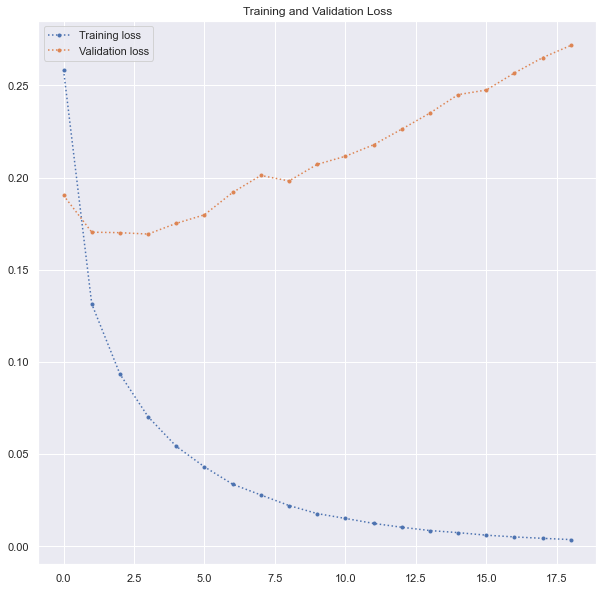

In [31]:
metric_to_plot = "loss"
plt.plot(history.epoch, history.history[metric_to_plot], ".:", label="Training loss")
plt.plot(history.epoch, history.history["val_" + metric_to_plot], ".:", label="Validation loss")
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [32]:
model = keras.models.load_model(best_model_file_name)
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))

Accuracy:  0.93125
Precision:  0.9271428571428572
Recall:  0.9360576923076923
F1 Score:  0.9315789473684211


## LSTM model

In [33]:
best_model_file_name = "models/best_model_LSTM_with_GloVe.hdf5"

def get_simple_GloVe_model():
    model = Sequential()
    model.add(Embedding(vocab_size, 
                        300, 
                        weights=[embedding_matrix], 
                        input_length=max_length,
                        trainable=False))
    model.add(LSTM(100))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

callbacks=[
    keras.callbacks.EarlyStopping(monitor="val_loss", 
                                  patience=15, 
                                  verbose=1, 
                                  mode="min", 
                                  restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath=best_model_file_name, 
                                    verbose=1, 
                                    save_best_only=True)
]

model = get_simple_GloVe_model()
print(model.summary())

model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

history = model.fit(X_train, 
                    y_train, 
                    epochs=50, 
                    validation_data=(X_test, y_test), 
                    callbacks=callbacks)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40, 300)           76332600  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

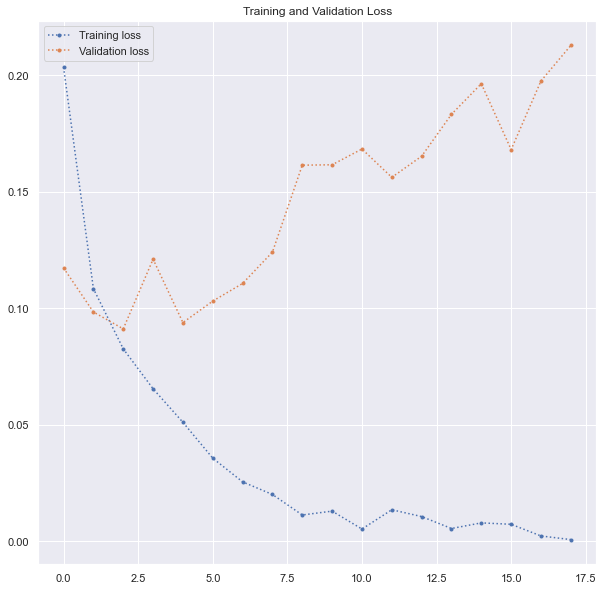

In [34]:
metric_to_plot = "loss"
plt.plot(history.epoch, history.history[metric_to_plot], ".:", label="Training loss")
plt.plot(history.epoch, history.history["val_" + metric_to_plot], ".:", label="Validation loss")
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [35]:
model = keras.models.load_model(best_model_file_name)
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))

Accuracy:  0.963701923076923
Precision:  0.9670702179176756
Recall:  0.9600961538461539
F1 Score:  0.9635705669481303


# Make Final Kaggle Submission

In [36]:
y_pred_test = model.predict_classes(padded_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [37]:
submit_predictions_df = pd.DataFrame()
submit_predictions_df['id'] = test_df['id']
submit_predictions_df['label'] = y_pred_test.astype(int)

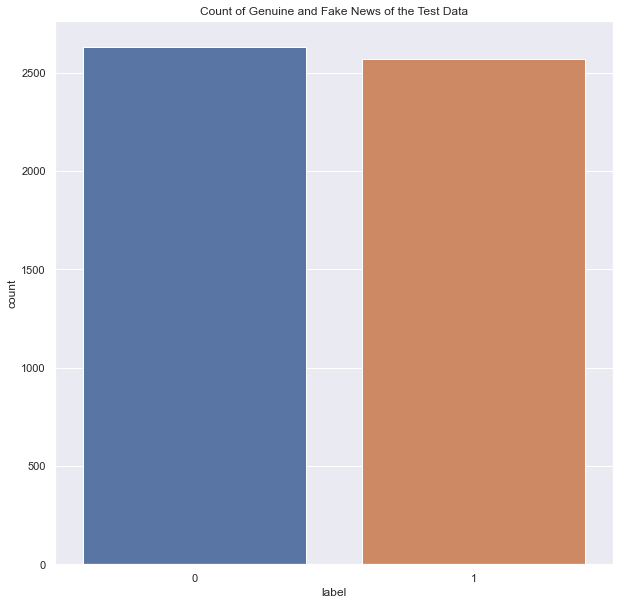

In [38]:
sns.countplot(submit_predictions_df['label'])
plt.title("Count of Genuine and Fake News of the Test Data")
plt.show()

In [39]:
submit_predictions_df.to_csv('kaggle_submissions/submit_glove_lstm.csv',index=False)

Finally, uploaded my submission on Kaggle and checked the result.

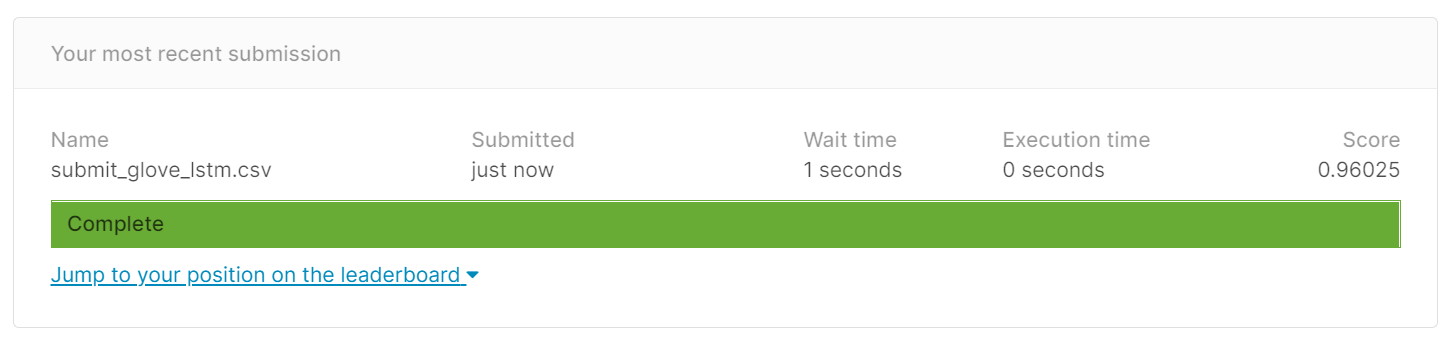

Thanks for visiting!